# Feature Analysis

This section aims to analyze feature correlations and plot the distubitions

In [ ]:
!pip install tqdm
!pip install boruta
!pip install mrmr_selection
!pip install minepy
!pip install keras_bed_sequence
!pip install barplots
!pip install seaborn

In [ ]:
import pickle
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import entropy
from minepy import MINE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from boruta import BorutaPy
from multiprocessing import cpu_count
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from mrmr import mrmr_classif

In [ ]:
epigenomes = {
        "promoters": {},
        "enhancers": {}
    }

labels = {
        "promoters": {},
        "enhancers": {}
    }

binarized_labels = {
    "promoters": {},
    "enhancers": {}
}

with open('./epigenomes/epigenomes_enhancers.pkl', 'rb') as f:
    epigenomes["enhancers"] = pickle.load(file=f)
with open('./epigenomes/epigenomes_promoters.pkl', 'rb') as f:
    epigenomes["promoters"] = pickle.load(file=f)
with open('./epigenomes/labels_enhancers.pkl', 'rb') as f:
    labels["enhancers"] = pickle.load(file=f)
with open('./epigenomes/labels_promoters.pkl', 'rb') as f:
    labels["promoters"] = pickle.load(file=f)
with open('./epigenomes/binarized_labels_promoters.pkl', 'rb') as f:
    binarized_labels['promoters'] = pickle.load(file=f)
with open('./epigenomes/binarized_labels_enhancers.pkl', 'rb') as f:
    binarized_labels['enhancers'] = pickle.load(file=f)

In [ ]:
p_value_threshold = 0.01 #if the pvalue is greater than 0.01 the correlation is not statistically significant
correlation_threshold = 0.05

uncorrelated = {
    region: set()
    for region in epigenomes
}

In [ ]:
for region, x in epigenomes.items():
    for column in tqdm(x.columns, desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
        correlation, p_value = pearsonr(x[column].values.ravel(), labels[region].values.ravel())
        if p_value > p_value_threshold and correlation < correlation_threshold:
            uncorrelated[region].add(column)

Running Pearson test for promoters:   0%|          | 0/562 [00:00<?, ?it/s]

Running Pearson test for enhancers:   0%|          | 0/562 [00:00<?, ?it/s]

In [ ]:
for region, x in epigenomes.items():
    for column in tqdm(x.columns, desc=f"Running Spearman test for {region}", dynamic_ncols=True, leave=False):
        correlation, p_value = spearmanr(x[column].values.ravel(), labels[region].values.ravel())
        if p_value > p_value_threshold and correlation < correlation_threshold:
            uncorrelated[region].add(column)

Running Spearman test for promoters:   0%|          | 0/562 [00:00<?, ?it/s]

Running Spearman test for enhancers:   0%|          | 0/562 [00:00<?, ?it/s]

In [ ]:
uncorrelated

{'promoters': {'ARNT', 'NBN', 'ZNF737'}, 'enhancers': {'SNRNP70', 'ZNF382'}}

### Fingind extremely correlated features

In [ ]:
p_value_threshold = 0.01 # if the p-value is lower than 0.01 we reject null hypothesis
correlation_threshold = 0.85

In [ ]:
extremely_correlated = {
    region: set()
    for region in epigenomes
}

scores = {
    region: []
    for region in epigenomes
}

for region, x in epigenomes.items():
    for i, column in tqdm(
        enumerate(x.columns),
        total=len(x.columns), desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
        for feature in x.columns[i+1:]:
            correlation, p_value = pearsonr(x[column].values.ravel(), x[feature].values.ravel())
            correlation = np.abs(correlation)
            scores[region].append((correlation, column, feature))
            if p_value < p_value_threshold and correlation > correlation_threshold:
                print(region, column, feature, correlation)
                
                #The less relevant feature is the one with the lower Entropy
                if entropy(x[column]) > entropy(x[feature]):
                    extremely_correlated[region].add(feature)
                else:
                    extremely_correlated[region].add(column)

Running Pearson test for promoters:   0%|          | 0/562 [00:00<?, ?it/s]

promoters ZCCHC11 ZNF580 0.8741019795205439
promoters ZCCHC11 ZNF331 0.8756676121119449
promoters ZCCHC11 ZNF614 0.8696609757713382
promoters ZCCHC11 CBX5 0.8758927966607286
promoters ZCCHC11 NFKBIZ 0.8528950896287755
promoters ZCCHC11 ATF6 0.8828183310262756
promoters ZCCHC11 ZBTB49 0.8595340861774527
promoters ZCCHC11 ZNF511 0.8748152809489599
promoters ZCCHC11 ZNF124 0.8908361046485254
promoters ZCCHC11 KLF16 0.8770590228575194
promoters ZCCHC11 ZFP36L2 0.8693814385942925
promoters ZCCHC11 IKZF5 0.8577494070701024
promoters ZCCHC11 KDM4B 0.8978056962666936
promoters ZCCHC11 SMAD3 0.9113276040520956
promoters ZCCHC11 SP140L 0.8781506902099527
promoters ZCCHC11 TSC22D2 0.8918173634286957
promoters ZCCHC11 ZGPAT 0.8664147712446668
promoters ZCCHC11 ZBTB44 0.8540228218539611
promoters ZCCHC11 ZNF792 0.8664891863128923
promoters ZCCHC11 ERF 0.8719485015160711
promoters ZCCHC11 KLF11 0.871727138848279
promoters ZCCHC11 HDAC2 0.8742432286635005
promoters ZCCHC11 MIER3 0.8637587611465115
pr

Running Pearson test for enhancers:   0%|          | 0/562 [00:00<?, ?it/s]

enhancers PPARG RXRB 0.8540750100442368
enhancers ZNF205 ERF 0.860357601884788
enhancers STAG1 RAD21 0.8919695783799217
enhancers ZFX ZFY 0.8533975528369036
enhancers SOX13 ARID5B 0.8558427594631695
enhancers SOX13 SOX5 0.9567474565697272
enhancers SOX13 SOX6 0.8574754863437235
enhancers SOX13 GATAD2A 0.8567415141294481
enhancers ZNF580 IRF2 0.8549436189999126
enhancers ZNF580 ZNF614 0.8763438138955877
enhancers ZNF580 KLF16 0.8654635961886755
enhancers ZNF580 IKZF5 0.8679280399630445
enhancers ZNF580 ZGPAT 0.8724989691384161
enhancers ZNF580 ZNF792 0.8545138318146965
enhancers ZNF580 ERF 0.9104410865522199
enhancers ZNF580 ARID4B 0.8519735889165794
enhancers ZNF580 MXD4 0.8562235695685233
enhancers ZNF580 KDM3A 0.8614457702355099
enhancers ZNF580 RBPJ 0.8639242866937543
enhancers ZNF331 LCOR 0.852937449105612
enhancers ZNF331 SMAD3 0.8560368141476313
enhancers ZNF331 ZGPAT 0.8530955451406285
enhancers ZNF331 ERF 0.8541494385609685
enhancers ZNF331 HDAC2 0.8700366037537248
enhancers ZN

In [ ]:
extremely_correlated

{'promoters': {'AHR',
  'ARID4B',
  'ARID5B',
  'ATF2',
  'ATF6',
  'BCL3',
  'CBFB',
  'CBX5',
  'CEBPG',
  'CREB3',
  'DLX6',
  'DMAP1',
  'DNMT3B',
  'DZIP1',
  'E2F5',
  'EEA1',
  'ELF3',
  'ERF',
  'ETV5',
  'ETV6',
  'FOXA1',
  'FOXA3',
  'FOXO1',
  'FOXP4',
  'GATAD2A',
  'GLI4',
  'GMEB1',
  'HBP1',
  'HDAC2',
  'HMG20A',
  'HMG20B',
  'HOMEZ',
  'HOXA5',
  'IKZF4',
  'IKZF5',
  'IRF2',
  'IRF5',
  'JUND',
  'KAT7',
  'KAT8',
  'KDM3A',
  'KDM4B',
  'KLF11',
  'KLF16',
  'KLF9',
  'KMT2A',
  'KMT2B',
  'LCOR',
  'MAFK',
  'MED1',
  'MED13',
  'MIER3',
  'MIXL1',
  'MXD1',
  'MXD3',
  'MXD4',
  'MYRF',
  'NFAT5',
  'NFATC3',
  'NFKB2',
  'NFKBIZ',
  'NFYA',
  'NFYB',
  'NKX3-1',
  'NR0B2',
  'NRL',
  'PITX1',
  'POLR2A',
  'PPARG',
  'RBPJ',
  'RCOR2',
  'RERE',
  'RXRB',
  'SAP130',
  'SATB2',
  'SIX4',
  'SMAD1',
  'SMAD3',
  'SMAD4',
  'SMAD9',
  'SOX13',
  'SOX18',
  'SOX5',
  'SP140L',
  'STAG1',
  'SUZ12',
  'TAF1',
  'TBX2',
  'TEAD3',
  'TFDP2',
  'TGIF2',
  'THRA',
  'T

We run MIC on features to discard.

In [ ]:
for region, x in epigenomes.items():
    for column in tqdm(uncorrelated[region], desc=f"Running MINE test for {region}", dynamic_ncols=True, leave=False):
        mine = MINE()
        mine.compute_score(x[column].values.ravel(), labels[region].values.ravel())
        score = mine.mic()
        if score < correlation_threshold:
            print(region, column, score)
        else:
            uncorrelated[region].remove(column)

Running MINE test for promoters:   0%|          | 0/3 [00:00<?, ?it/s]

promoters ZNF737 0.015255144348224928
promoters NBN 0.008774155615190522
promoters ARNT 0.00955232515433818


Running MINE test for enhancers:   0%|          | 0/2 [00:00<?, ?it/s]

enhancers ZNF382 0.005574408218009011
enhancers SNRNP70 0.007063210149030621


In [ ]:
uncorrelated

{'promoters': {'ARNT', 'NBN', 'ZNF737'}, 'enhancers': {'SNRNP70', 'ZNF382'}}

### Creating scatter plots to show correlation between features

Most correlated features from promoters epigenomes


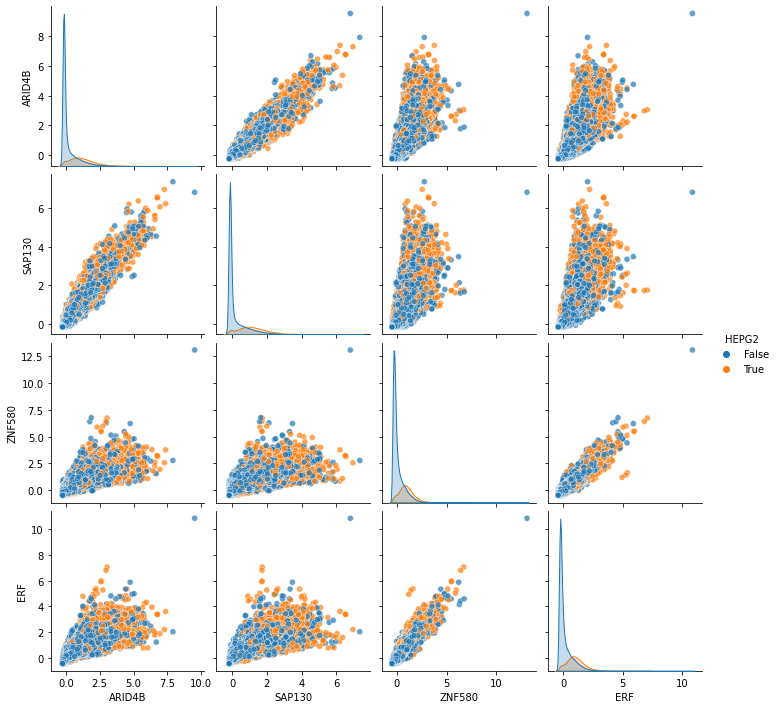

Most correlated features from enhancers epigenomes


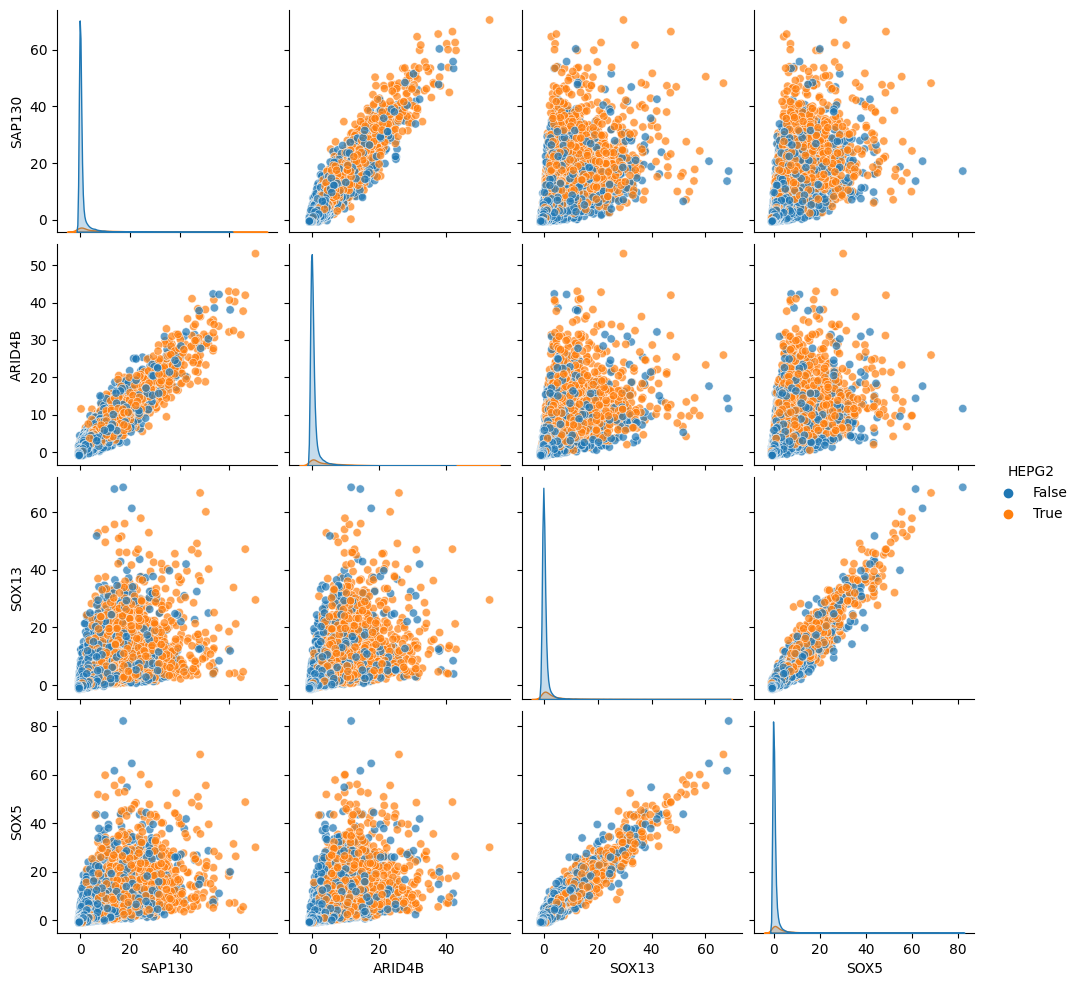

In [ ]:
scores = {
    region:sorted(score, key=lambda x: np.abs(x[0]), reverse=True)
    for region, score in scores.items()
}
for region, x in epigenomes.items():
    _, firsts, seconds = list(zip(*scores[region][:2]))
    columns = list(set(firsts+seconds))
    print(f"Most correlated features from {region} epigenomes")

    sns.pairplot(
      pd.concat([
          x[columns],
          binarized_labels[region],
      ], axis=1), 
      hue=binarized_labels[region].columns[0],
      plot_kws={'alpha':0.7} 
    )
    plt.show()

### Feature Distibution findings

Top 5 different features from promoters.


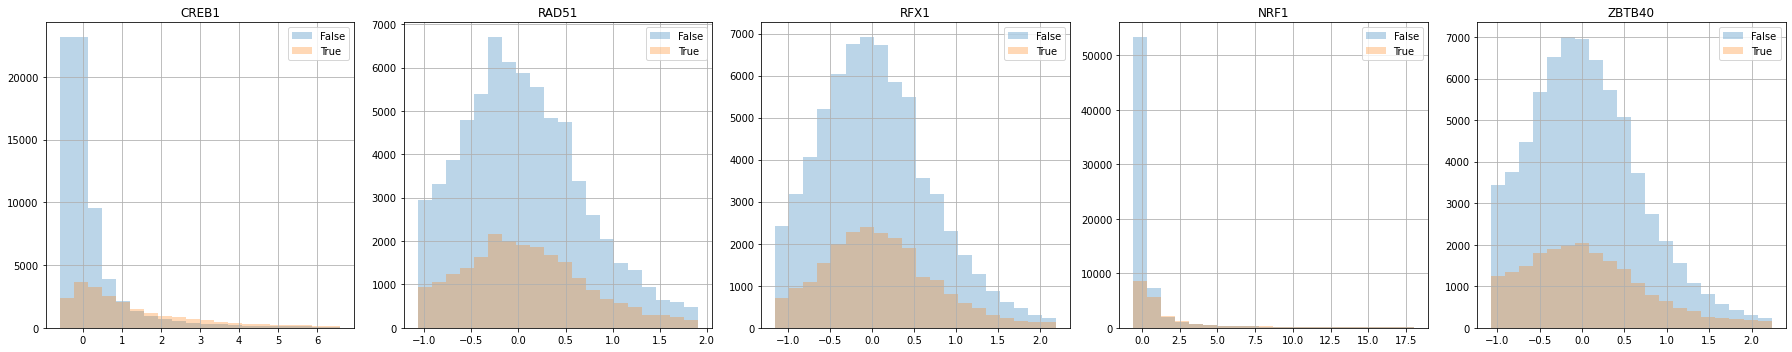

Top 5 different features from enhancers.


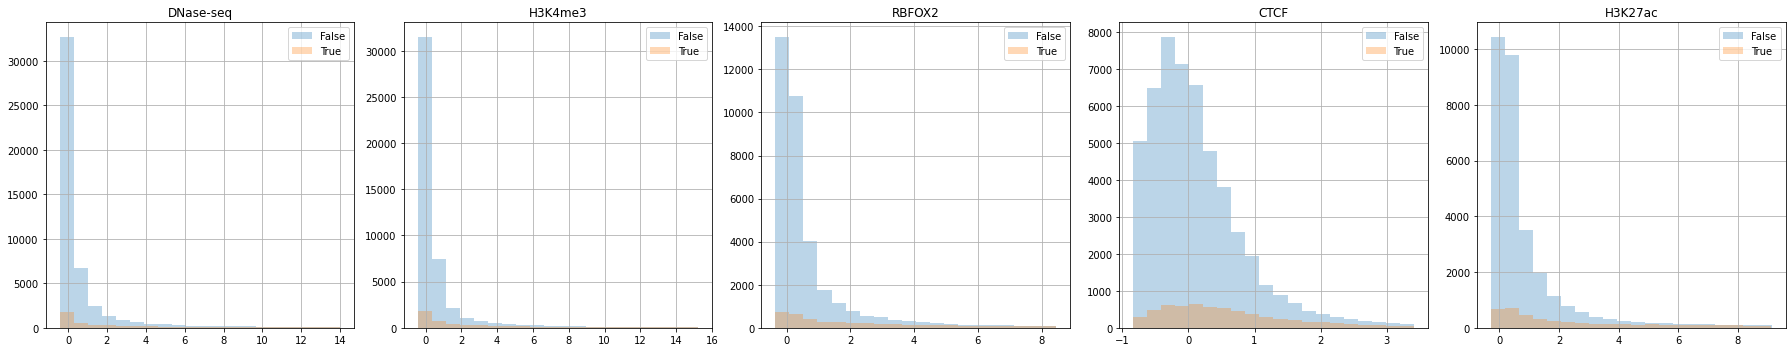

In [ ]:
def get_top_most_different(dist, n:int):
    return np.argsort(-np.mean(dist, axis=1).flatten())[:n]

top_number = 5

for region, x in epigenomes.items():
    dist = euclidean_distances(x.T)
    most_distance_columns_indices = get_top_most_different(dist, top_number)
    columns = x.columns[most_distance_columns_indices]
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
    print(f"Top {top_number} different features from {region}.")

    for column, axis in zip(columns, axes.flatten()):
        head, tail = x[column].quantile([0.05, 0.95]).values.ravel()
        
        mask = ((x[column] < tail) & (x[column] > head)).values
        
        cleared_x = x[column][mask]
        cleared_y = binarized_labels[region].values.ravel()[mask]

        for bin_value in np.unique(binarized_labels[region]):
            cleared_x[cleared_y==bin_value].hist(ax=axis, bins=20, alpha = 0.3)
        axis.legend(np.unique(binarized_labels[region]))

        axis.set_title(column)
    fig.tight_layout()
    plt.show()

### Dropping uncorrelated output features

In [ ]:
for region, x in epigenomes.items():
    epigenomes[region] =x.drop(columns=[
        col
        for col in uncorrelated[region]
        if col in x.columns
    ])

## Feature Selection Using Boruta and MRMR

In [ ]:
def execute_boruta(X: pd.DataFrame, y: pd.DataFrame, n_iter: int):
    boruta_selector = BorutaPy(
            RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5),
            n_estimators='auto',
            verbose=1,
            alpha=0.05, # p_value threshold
            max_iter=n_iter, 
            random_state=42,
    )
    boruta_selector.fit(X.values, y)
    return list(X.columns[boruta_selector.support_])


Random Forest Classifier was used for the boruta feature selection.

In [ ]:
#Dictionaries to keep the selected features over the various holdouts
holdouts_boruta_features = {'promoters': [],
                            'enhancers':[]}

for region, x in tqdm(epigenomes.items(), desc = f"Running 5-Stratified Shuffle Split for searching the best features for {region} regions"):
    
    sss = StratifiedShuffleSplit(n_splits=5, train_size=0.8, test_size=0.2,random_state=42)
    
    for train_index, _ in sss.split(x, binarized_labels[region]):
        
        #Let's index our dataframe and extract the current split data
        holdout_x = x.iloc[train_index]
        holdout_y = binarized_labels[region].iloc[train_index]
        
        print('Running boruta feature selection')
        boruta_features = execute_boruta(X = holdout_x, y = holdout_y, n_iter = 100)
        
        print('Running mRMR feature selection')
        
        holdouts_boruta_features[region].append( boruta_features)



{'promoters': chrom                                 NR2F6   ZCCHC11     PPARG      AGO2  \
 chrom chromStart chromEnd  strand                                           
 chr1  628964     629220    +      -0.951807 -0.225806 -0.386266 -0.241252   
       629013     629269    +      -0.879518 -0.078341 -0.313305 -0.241252   
       629642     629898    +      -0.951807 -0.451613 -0.287554 -0.329650   
       629847     630103    +      -0.132530  0.165899 -0.055794 -0.340700   
       629905     630161    +      -0.132530  0.193548 -0.111588 -0.357274   
 ...                                     ...       ...       ...       ...   
 chrX  154441877  154442133 +      -0.638554 -0.050691 -0.433476  0.484346   
       154584927  154585183 +      -0.951807 -0.640553 -0.532189 -0.364641   
 chrY  1452882    1453138   -      -0.951807 -0.640553 -0.532189 -0.364641   
       2500959    2501215   -      -0.951807 -0.640553 -0.532189 -0.364641   
       14055973   14056229  +      -0.951807 -0.640

: 

In [ ]:
with open('./features/promoters_features.pkl', 'wb') as f:
    pickle.dump(holdouts_boruta_features['promoters'][0], file=f)

In [ ]:
intersection = set.intersection( set(holdouts_boruta_features['enhancers'][0]),
                      set(holdouts_boruta_features['enhancers'][1]),
                      set(holdouts_boruta_features['enhancers'][2]),
                      set(holdouts_boruta_features['enhancers'][3]),
                      set(holdouts_boruta_features['enhancers'][4]))
len(intersection)

In [ ]:

with open('./features/enhancers.pkl', 'wb') as f:
    pickle.dump(list(intersection), file=f)